In [1]:
%load_ext autoreload
%autoreload 2
import pyvisa
import time
from PyTLPMX import TLPMX
import numpy as np
import numpy.matlib
import clr
from matplotlib import pyplot as plt
from datetime import datetime
from timeit import default_timer as timer
from scipy.optimize import curve_fit
import csv

clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.DeviceManagerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericPiezoCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericMotorCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.KCube.PositionAlignerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.KCube.PiezoCLI.dll")

# Import CLIs
from Thorlabs.MotionControl.DeviceManagerCLI import *
from Thorlabs.MotionControl.GenericMotorCLI import *
from Thorlabs.MotionControl.KCube.PositionAlignerCLI import *
from Thorlabs.MotionControl.KCube.PiezoCLI import *
from Thorlabs.MotionControl.GenericPiezoCLI.Piezo import *
from System import Decimal 
from pyximc import *
from ConnectHardware import *
from Analytics import *
from HardwareControl import *

In [2]:
# connect to lock-in amps
rm = pyvisa.ResourceManager()
amp1 = rm.open_resource('GPIB0::8::INSTR')
amp2 = rm.open_resource('GPIB0::9::INSTR')
print(rm.list_resources())

('ASRL3::INSTR', 'ASRL4::INSTR', 'GPIB0::8::INSTR', 'GPIB0::9::INSTR')


In [3]:
# Connect to piezo controller

# enter serial num
piezo = connectKPZ("29252602")
print("Setting Zero Point")
piezo.SetZero()

Connecting to device
Getting device info
KPZ101 Piezo Drive
Setting Zero Point


In [ ]:
numScans = 10
positions = np.array(np.linspace(0, 20, 10))
shifts, TM_paras, TE_paras, t_stamps = estimateShift(piezo, amp1, amp2, numScans, positions)
print(f"Mean shift: {np.mean(shifts)}")
fig2, ax = plt.subplots()
ax.plot(np.divide(t_stamps,60), shifts, "b.-")
ax.set_ylabel("Shift (um)")
ax.set_xlabel("Time (min)")
#ax.axhline(np.mean(shifts), color="red")
print("Mean: {}".format(np.mean(shifts)))
print("SD: {}".format(np.std(shifts)))

In [ ]:
numScans = 10
positions = np.array(np.linspace(0, 20, 10))
shifts, TM_paras, TE_paras, t_stamps = estimateShift(piezo, amp1, amp2, numScans, positions)
print(f"Mean shift: {np.mean(shifts)}")

Mean: 1.0458435497124814
SD: 0.30472801288055656


[autoreload of HardwareControl failed: Traceback (most recent call last):
  File "C:\Conda5\lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "C:\Conda5\lib\site-packages\IPython\extensions\autoreload.py", line 471, in superreload
    module = reload(module)
  File "C:\Conda5\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "M:\Black silver project\GH-shift-biosensor-main\HardwareControl.py", line 349
    now = 0
           ^
IndentationError: unindent does not match any outer indentation level
]


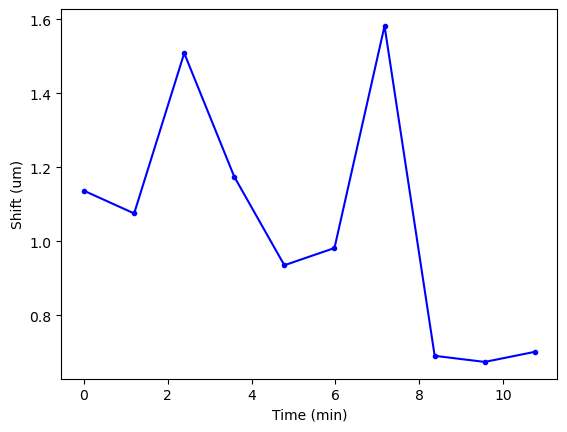

In [5]:
fig2, ax = plt.subplots()
ax.plot(np.divide(t_stamps,60), shifts, "b.-")
ax.set_ylabel("Shift (um)")
ax.set_xlabel("Time (min)")
#ax.axhline(np.mean(shifts), color="red")
print("Mean: {}".format(np.mean(shifts)))
print("SD: {}".format(np.std(shifts)))

In [75]:
positions = np.array(np.linspace(0, 20, 5))
TE_signal, TM_signal, TE_data, TM_data, t_stamps_all, pos_tstamps = signalScan(amp1, amp2, positions, piezo)

Moved to 0V

Taking measurement..
Starting 6.5 seccond measurement....
Done
Moved to 0.0183111056855983V

Taking measurement..
Starting 6.5 seccond measurement....
Done
6.426745299999311
Moved to 37.6270332956938V

Taking measurement..
Starting 6.5 seccond measurement....
Done
12.887215599999763
Moved to 56.7461165196692V

Taking measurement..
Starting 6.5 seccond measurement....
Done
19.381984999999986
Moved to 56.3066499832148V

Taking measurement..
Starting 6.5 seccond measurement....
Done
25.868664600000557
Scan completed



In [76]:
TM_para, TM_pcov = curve_fit(linearFunc, positions, TM_data)
TE_para, TE_pcov = curve_fit(linearFunc, positions, TE_data)

# Calculate shift from x-intercepts
TM_intercept = -TM_para[1] / TM_para[0]
TE_intercept = -TE_para[1] / TE_para[0]
shift = TM_intercept - TE_intercept
print(shift)

1.7580540069539374



Shift: 1.7580540069539374 um
-0.002709045621344809
-0.0028169658853980538


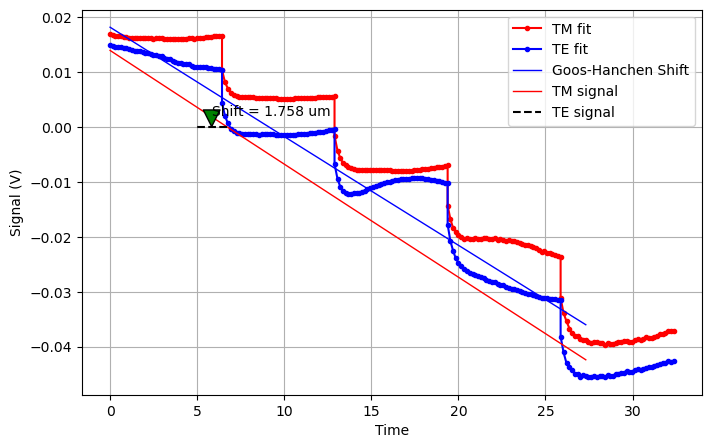

In [77]:
# PLOT RESULTS
fig, ax = plt.subplots(figsize=(8,5))

# calculate error and plot graph
ax.plot(t_stamps_all, TM_signal, "r.-")
ax.plot(t_stamps_all, TE_signal, "b.-")

TM_fit = TM_para[0]*np.array(positions) + TM_para[1]
TE_fit = TE_para[0]*np.array(positions) + TE_para[1]
ax.plot(pos_tstamps, TM_fit, 'b', label='OLS TM model', linewidth=1)
ax.plot(pos_tstamps, TE_fit, 'r', label='OLS TE model', linewidth=1) 
"""TM_fit = TM_para[0]*np.array(positions) + TM_para[1]
ax.plot(positions, TM_fit, 'b', label='OLS TM model', linewidth=1)

ax.errorbar(positions, TE_signal, TE_err, fmt='x', color="orange")
TE_fit = TE_para[0]*np.array(positions) + TE_para[1]
ax.plot(positions, TE_fit, 'r', label='OLS TE model', linewidth=1) 
"""
# Labels
ax.set_xlabel('Time')
ax.set_ylabel('Signal (V)')
ax.grid()

print("\nShift: {} um".format(shift))

# Label shift
shiftLabel = "Shift = {} um".format(np.round(shift, 3))
xCoord = np.mean([TM_intercept, TE_intercept])
yCoord = ax.get_ylim()[1]*0.1
ax.hlines(0, TM_intercept, TE_intercept, colors='black', linestyles='dashed')
ax.annotate(shiftLabel, xy =(xCoord, 0), 
                xytext =(xCoord, yCoord),  
                arrowprops = dict(facecolor ='green', 
                                  shrink = 0.05),)
# add legend
legend_drawn_flag = True
plt.legend(["TM fit", "TE fit","Goos-Hanchen Shift", "TM signal", "TE signal"], loc=0, frameon=legend_drawn_flag)
print(TM_para[0])
print(TE_para[0])
plt.show()

In [12]:
# Stop Polling and Disconnect
print("Disconnecting")
piezo.StopPolling()
time.sleep(0.5)
piezo.Disconnect()
rm.close()

Disconnecting
